In [1]:
import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re


from rmexp import schema


In [2]:
# exps = ['face3pool3pingpong3lego3',
#         'face4pool4pingpong4lego4', 'face5pool4pingpong4lego4', 'face5pool4pingpong4lego5',
#         'face5pool5pingpong4lego5', 'face5pool5pingpong5lego5', 'face5pool5pingpong5lego6',
#         'face5pool6pingpong5lego6',
#         'face5pool6pingpong6lego6', 'face5pool6pingpong6lego7', 'face5pool7pingpong6lego7',
#         'face5pool7pingpong7lego7',
#         'face8pool8pingpong8lego8']

exps = ['face3pool3pingpong3lego3',
        'face4pool4pingpong4lego4', 
        'face5pool4pingpong4lego5',
        'face5pool5pingpong5lego5',
        'face5pool6pingpong5lego6',
        'face5pool6pingpong6lego7',
        'face5pool7pingpong7lego7',
        'face8pool8pingpong8lego8']

exps_clients = map(lambda exp: sum(map(int, re.findall('\d+', exp))) , exps)

def exp_app_clients(name):
    r = re.findall('\d+', name)
    r = map(int, r)
    return dict(zip(['face', 'pool', 'pingpong', 'lego'], r))

print(exps_clients)

schemes = ['baseline', 'cpushares', ]
apps = ['face', 'lego', 'pingpong', 'pool']

assert len(exps) == len(set(exps)), "redundant!"

def pretty_app(app):
    dct = {
        'face': 'FACE',
        'lego': 'LEGO',
        'pingpong': 'PING PONG',
        'pool': 'POOL',
    }
    return dct[app]

def pretty_scheme(scheme):
    dct = {
        'baseline': 'Gabriel',
        'cpushares': 'Our Allocator',
        'maxmin': 'Our Max-Min',
    }
    return dct[scheme]

app_bounds = {
    'lego': (600, 2700),
    'pingpong': (150, 230),
    'pool': (95, 105),
    'face': (370, 1000),
}

[12, 16, 18, 20, 22, 24, 26, 32]


## Max-Sum Utility

In [3]:
# compare total utility of different methods
total_utils = pd.DataFrame()

for scheme in schemes:
    for exp in exps:
        df = pd.read_sql(
            "select sum(utility)/count(distinct name) as utility from ExpLatency where name like %(name)s",
            schema.engine,
            params={'name': exp+'-'+scheme+'%'}
        )
        total_utils = total_utils.append({
            'exp': exp,
            'scheme': scheme,
            'total_utility': df['utility'].iat[0]
        }, ignore_index=True)
        
print(total_utils)

                         exp     scheme  total_utility
0   face3pool3pingpong3lego3   baseline   10039.578220
1   face4pool4pingpong4lego4   baseline    9495.794107
2   face5pool4pingpong4lego5   baseline    8648.864912
3   face5pool5pingpong5lego5   baseline    8950.159028
4   face5pool6pingpong5lego6   baseline    8679.324143
5   face5pool6pingpong6lego7   baseline    6392.107654
6   face5pool7pingpong7lego7   baseline    5845.263599
7   face8pool8pingpong8lego8   baseline    5374.858834
8   face3pool3pingpong3lego3  cpushares    9298.968603
9   face4pool4pingpong4lego4  cpushares   10367.267709
10  face5pool4pingpong4lego5  cpushares   11554.835350
11  face5pool5pingpong5lego5  cpushares   11660.839498
12  face5pool6pingpong5lego6  cpushares   11003.372856
13  face5pool6pingpong6lego7  cpushares   11092.083737
14  face5pool7pingpong7lego7  cpushares   11753.111236
15  face8pool8pingpong8lego8  cpushares   11773.695955


<IPython.core.display.Javascript object>


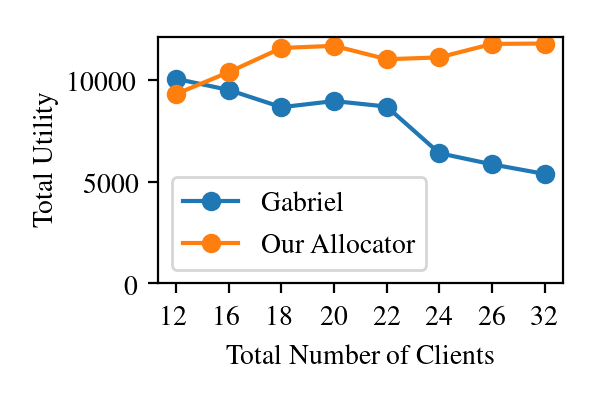

In [7]:
%matplotlib notebook

plt.figure(figsize=(3,2))
for scheme in schemes:
    plt.plot('exp', 'total_utility', 'o-', data=total_utils[total_utils['scheme'] == scheme], label=pretty_scheme(scheme))
plt.ylim([0, None])
plt.xticks(exps, exps_clients)
plt.xlabel('Total Number of Clients')
plt.ylabel('Total Utility')
plt.legend()
plt.tight_layout()
plt.savefig('fig-alloc-max-util.pdf')


<IPython.core.display.Javascript object>


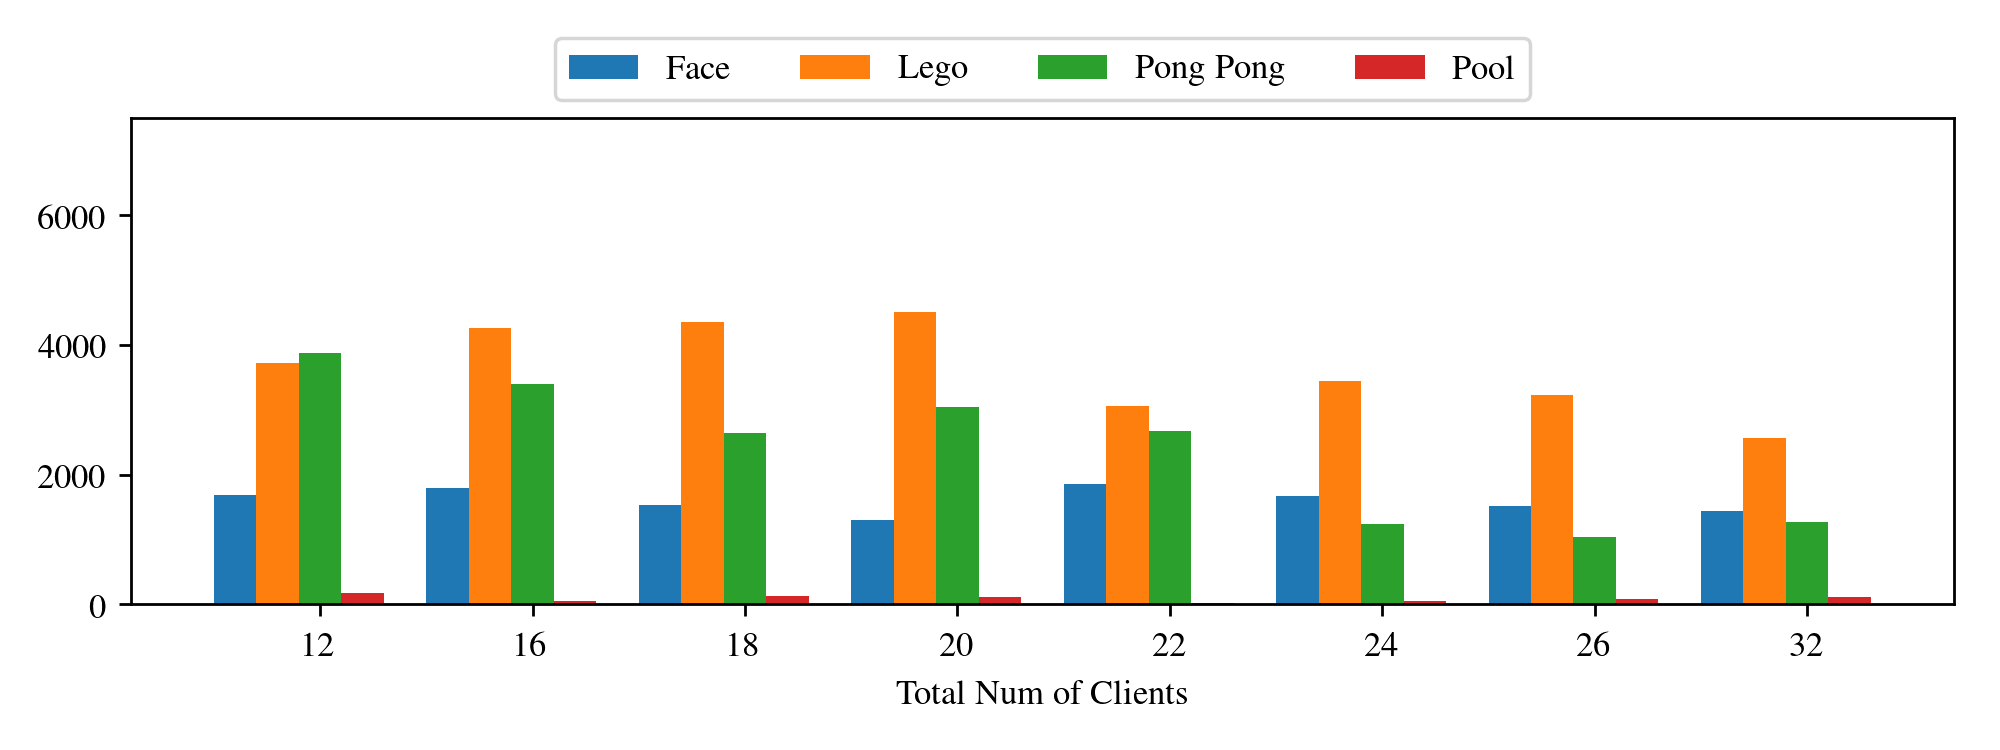

<IPython.core.display.Javascript object>


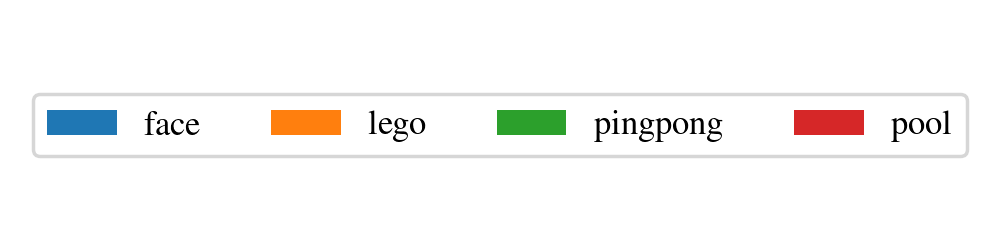

<IPython.core.display.Javascript object>


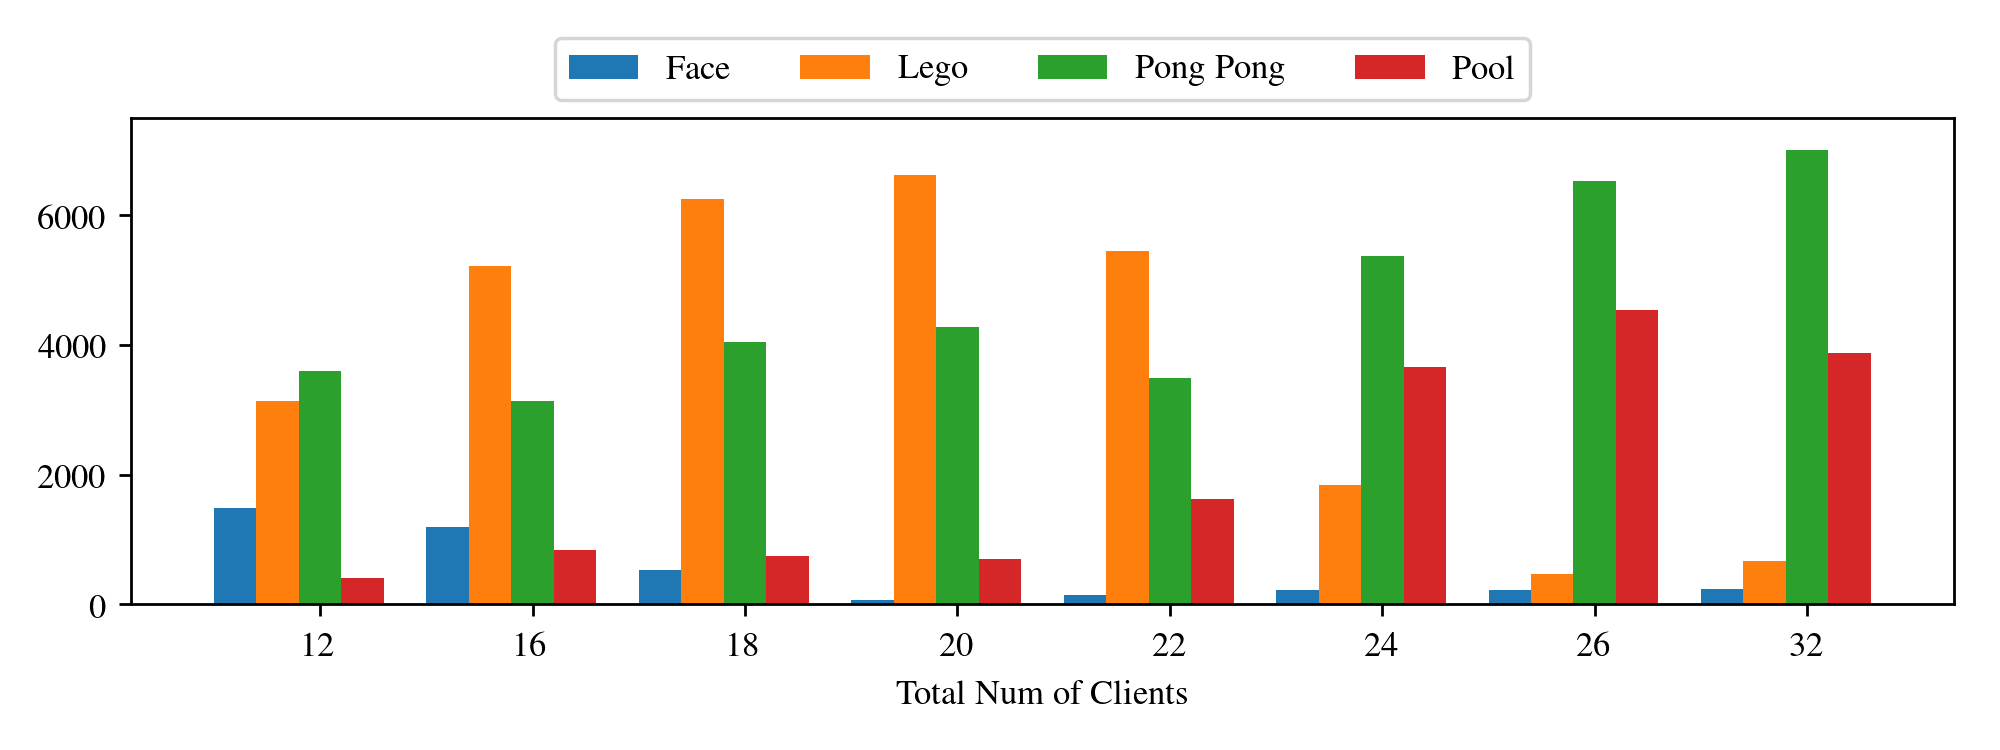

<IPython.core.display.Javascript object>


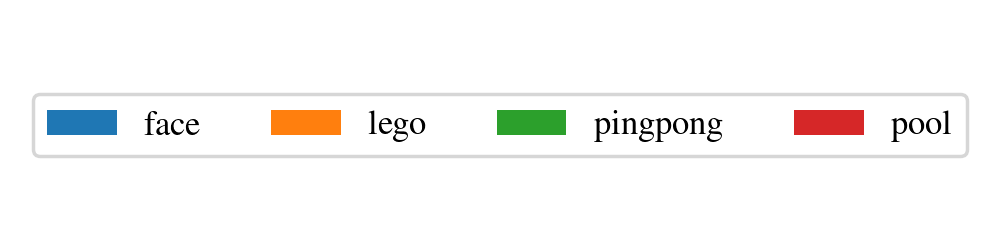

In [275]:
# plot breakdowns of individual apps

for scheme in schemes:
    app_utils = pd.DataFrame()
    
    for exp in exps:
        df = pd.read_sql(
            "select app, sum(utility) as utility from ExpLatency where name=%(name)s group by app",
            schema.engine,
            params={'name': exp+'-'+scheme}
        )
        df['exp'] = exp
        
        app_utils = app_utils.append(df, ignore_index=True)
        
#     print(app_utils)
    
    fig, ax = plt.subplots()
    ind = np.arange(len(exps))
    width = .2
    
    fig_legend = plt.figure(figsize=(4,1))
    
    lines=[]
    for i, app in enumerate(apps):
        ln = ax.bar(ind + width*i, app_utils[app_utils['app']==app]['utility'], width, label=pretty_app(app))
        lines.append(ln)
    fig_legend.legend(lines, apps, 'center', ncol=4)
    ax.set_xticks(ind + width * len(apps) / 2 )
    ax.set_xticklabels(exps_clients)
    ax.set_xlabel('Total Num of Clients')
    ax.set_ylim([0, 7500])
    fig.set_size_inches((8,3))
    ax.legend(loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=4)
    fig.tight_layout()
    fig.savefig('fig-alloc-{}.pdf'.format(scheme), bbox_inches='tight')
            

fig_legend.show()

In [8]:
# plot 90%-tile/avg latencies of individual apps
def plot_latency(exps, schemes, apps, prefix):

    for scheme in schemes:
        app_latency = pd.DataFrame()

        for exp in exps:
            df = pd.read_sql(
                "select name, app, reply as latency from ExpLatency where name like %(name)s",
                schema.engine,
                params={'name': exp+'-'+scheme+'%',}
            )

            for app in apps:
                df_app = df[df['app']==app]
                latency = np.percentile(df_app['latency'].values, 90)  # 90%-tile
                count = df_app['latency'].count()

                app_latency = app_latency.append({
                    'exp': exp,
                    'app': app,
                    'latency': latency,
                    'count': count
                    }, ignore_index=True)

    #     print(app_latency)

        fig, ax = plt.subplots()
        ind = np.arange(len(exps))
        
        legend_lns = []

        # per-app latency
        width = .18

        for i, app in enumerate(apps):
            x = ind + width*i
            y = app_latency[app_latency['app']==app]['latency'].values

            lb, ub = app_bounds[app]

            y1 = np.ones_like(y)
            y1[y < lb] = y[y < lb] / lb
            y1[np.logical_and(lb <= y, y <= ub)] = 1. + (y[np.logical_and(lb <= y, y <= ub)] - lb) / (ub - lb)
            y1[y > ub] = 1. + y[y > ub] / ub

            ln = ax.bar(x, y1, width, label=pretty_app(app))
            legend_lns.append(ln)

        ax.hlines(1., -.1, len(ind)-1+width*4, colors='k', linestyles='dotted')
        ax.hlines(2., -.1, len(ind)-1+width*4, colors='k', linestyles='dotted')

        ax.set_yticks([1., 2.])
        ax.set_yticklabels(['Tight\n bound', 'Loose\n bound'])
        ax.set_xticks(ind + width * len(apps) / 2 )
        ax.set_xticklabels(exps_clients)
        ax.set_xlabel('Total Number of Clients')
        ax.set_ylabel('Normalized Latency')
        ax.set_ylim([0, 4.])
#         ax.legend(loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=4, handletextpad=.3)

        fig.set_size_inches((4, 2))
        fig.tight_layout()
        print("Saving", prefix, scheme)
        fig.savefig('fig-{}-latency-{}.pdf'.format(prefix, scheme), bbox_inches='tight')
        
        # save legend to separate figure
        fig_legend = plt.figure(figsize=(4, .25))
        fig_legend.legend(legend_lns, map(pretty_app, apps), 'center', ncol=4)
        fig_legend.savefig('fig-{}-latency-legend.pdf'.format(prefix), bbox_inches='tight')


<IPython.core.display.Javascript object>


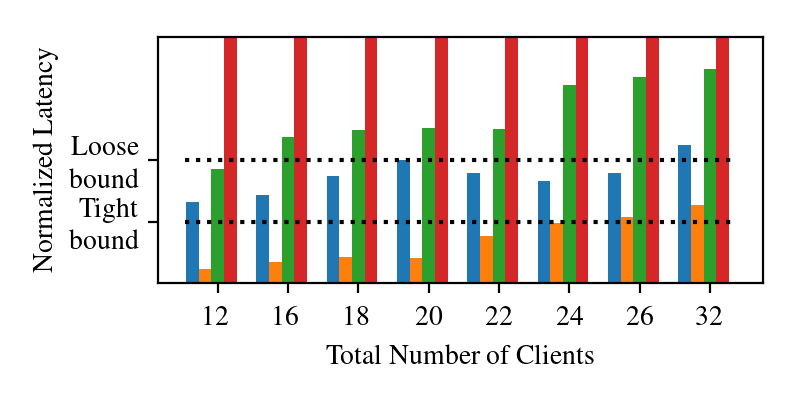

('Saving', 'alloc', 'baseline')


<IPython.core.display.Javascript object>


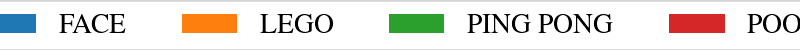

<IPython.core.display.Javascript object>


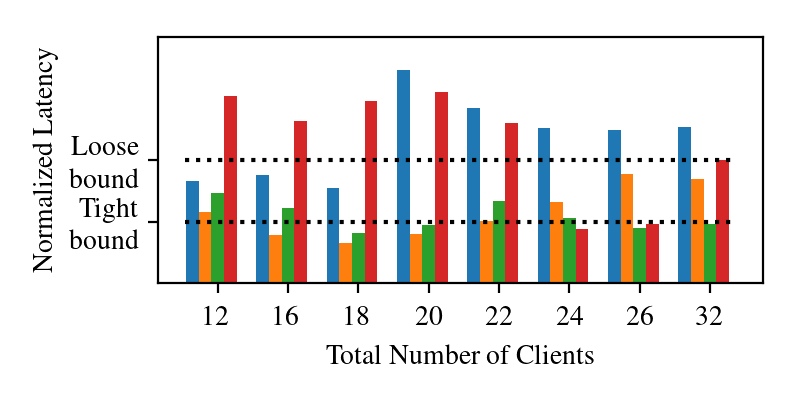

('Saving', 'alloc', 'cpushares')


<IPython.core.display.Javascript object>


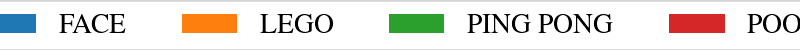

In [9]:
%matplotlib notebook
plot_latency(exps, schemes, apps, 'alloc')

<IPython.core.display.Javascript object>


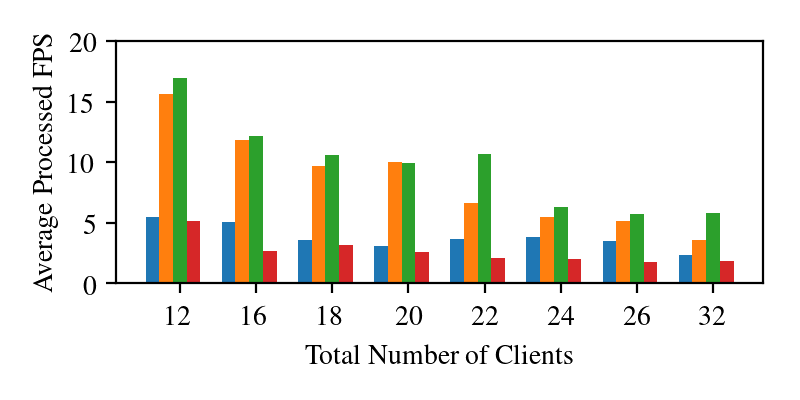

[3 4 5 5 5 5 5 8]
[5.48888889 5.07777778 3.56666667 3.10444444 3.62777778 3.83555556
 3.50888889 2.3875    ]
[3 4 5 5 6 7 7 8]
[15.58703704 11.81666667  9.66       10.00888889  6.61944444  5.46349206
  5.12222222  3.61944444]
[3 4 4 5 5 6 7 8]
[16.93888889 12.13888889 10.62222222  9.92666667 10.69444444  6.26666667
  5.72539683  5.82222222]
[3 4 4 5 6 6 7 8]
[5.11111111 2.66111111 3.19722222 2.62888889 2.09907407 1.99259259
 1.73968254 1.81805556]


<IPython.core.display.Javascript object>


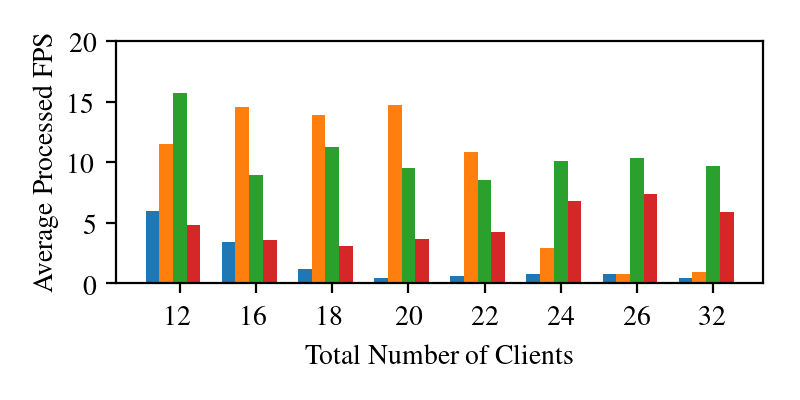

[3 4 5 5 5 5 5 8]
[5.97037037 3.45       1.19777778 0.48222222 0.64555556 0.77333333
 0.76444444 0.47638889]
[3 4 5 5 6 7 7 8]
[11.53333333 14.51666667 13.89111111 14.70222222 10.8037037   2.91746032
  0.76984127  0.93888889]
[3 4 4 5 5 6 7 8]
[15.7037037   8.93333333 11.25555556  9.52222222  8.57       10.09444444
 10.36507937  9.72777778]
[3 4 4 5 6 6 7 8]
[4.78333333 3.61944444 3.09722222 3.70222222 4.25833333 6.83518519
 7.36349206 5.925     ]


In [10]:
# Plot processed fps
for scheme in schemes:
    app_frames = pd.DataFrame()
    
    for exp in exps:
        df = pd.read_sql(
            "select app, count(*)/count(distinct name) as frames from ExpLatency where name like %(name)s group by app",
            schema.engine,
            params={'name': exp+'-'+scheme+'%',}
        )
        
        df['exp'] = exp
        
        app_frames = app_frames.append(df, ignore_index=True)
        
#     print(app_frames)
    
    fig, ax = plt.subplots()
    ind = np.arange(len(exps))
    width = .18
    
    for i, app in enumerate(apps):
        x = ind + width*i
        this_app = app_frames[app_frames['app']==app]
        this_app_clients = np.array([exp_app_clients(name)[app] for name in this_app['exp']])
        print(this_app_clients)
        # y is average fps
        y = this_app['frames'].values / (this_app_clients * 90)
        print(y)
        
        ax.bar(x, y, width, label=pretty_app(app))
    
    ax.set_xticks(ind + width * len(apps) / 2 )
    ax.set_xticklabels(exps_clients)
    ax.set_xlabel('Total Number of Clients')
    ax.set_ylabel('Average Processed FPS')
#     ax.set_yticks([0, 5, 10, 15])
    ax.set_ylim([0, 20])
#     ax.legend(loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=4)

    fig.set_size_inches((4, 2.))
    fig.tight_layout()
    fig.savefig('fig-alloc-fps-{}.pdf'.format(scheme), bbox_inches='tight')

## Combined Evaluation

<IPython.core.display.Javascript object>


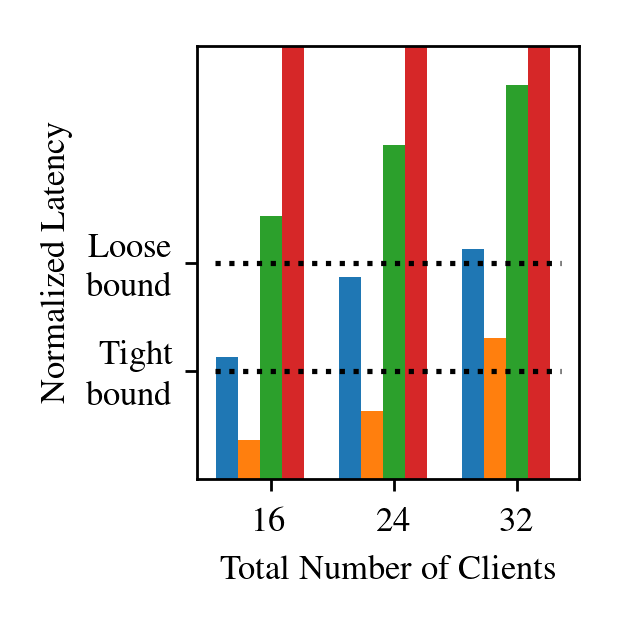

<IPython.core.display.Javascript object>


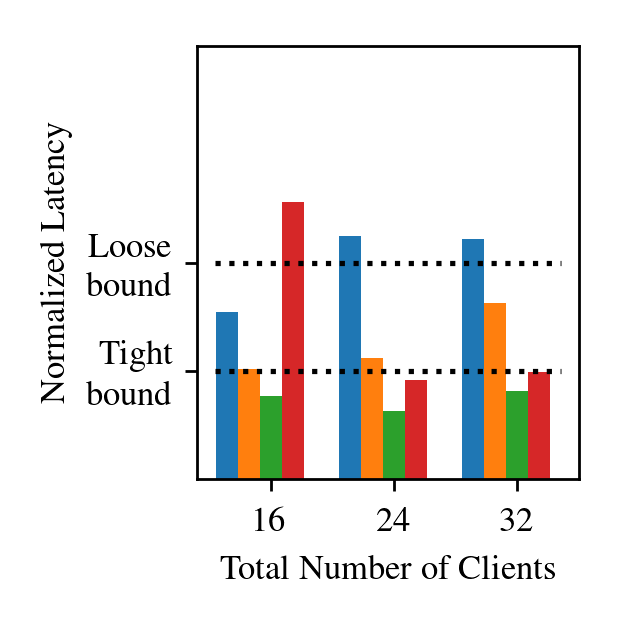

In [292]:
prefix = 'eval'
sec6_exps = [4, 6, 8]
for scheme in ['baseline', 'ours']:
    app_latency = pd.DataFrame()

    for exp in sec6_exps:
        df = pd.read_sql(
            "select name, app, reply as latency from ExpLatency where name=%(name)s",
            schema.engine,
            params={'name': 'sec6-{}-{}'.format(scheme, exp),}
        )

        for app in apps:
            df_app = df[df['app']==app]
            latency = np.percentile(df_app['latency'].values, 90)  # 90%-tile

            app_latency = app_latency.append({
                'exp': exp,
                'app': app,
                'latency': latency,
                }, ignore_index=True)

#     print(app_latency)

    fig, ax = plt.subplots()
    ind = np.arange(len(sec6_exps))

    # per-app latency
    width = .18

    for i, app in enumerate(apps):
        x = ind + width*i
        y = app_latency[app_latency['app']==app]['latency'].values

        lb, ub = app_bounds[app]

        y1 = np.ones_like(y)
        y1[y < lb] = y[y < lb] / lb
        y1[np.logical_and(lb <= y, y <= ub)] = 1. + (y[np.logical_and(lb <= y, y <= ub)] - lb) / (ub - lb)
        y1[y > ub] = 1. + y[y > ub] / ub

        ax.bar(x, y1, width, label=pretty_app(app))

    ax.hlines(1., -.1, len(ind)-1+width*4, colors='k', linestyles='dotted')
    ax.hlines(2., -.1, len(ind)-1+width*4, colors='k', linestyles='dotted')

    ax.set_yticks([1., 2.])
    ax.set_yticklabels(['Tight\n bound', 'Loose\n bound'])
    ax.set_xticks(ind + width * len(apps) / 2 )
    ax.set_xticklabels(np.array(sec6_exps)*4)
    ax.set_xlabel('Total Number of Clients')
    ax.set_ylabel('Normalized Latency')
    ax.set_ylim([0, 4.])
#     ax.legend(loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=4, handletextpad=.3)

    fig.set_size_inches((2.5, 2.5))
    fig.tight_layout()
    fig.savefig('fig-{}-latency-{}.pdf'.format(prefix, scheme), bbox_inches='tight')

<IPython.core.display.Javascript object>


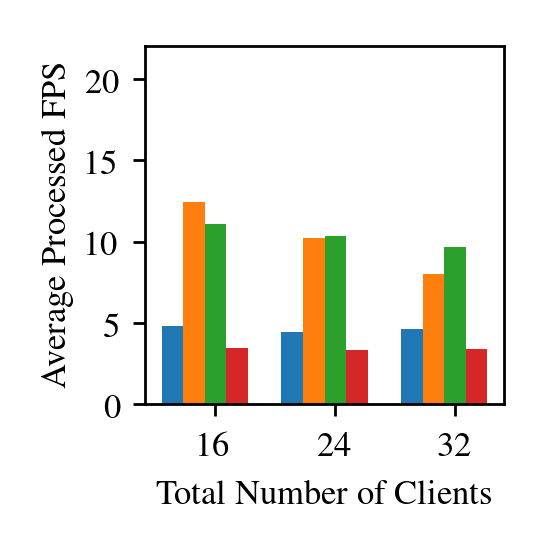

[3 4 4 5 6 6 7 8]
[4.83333333 4.44444444 4.61111111]
[3 4 4 5 6 6 7 8]
[12.44722222 10.24444444  7.98888889]
[3 4 4 5 6 6 7 8]
[11.09166667 10.36944444  9.68055556]
[3 4 4 5 6 6 7 8]
[3.43333333 3.33888889 3.38611111]


<IPython.core.display.Javascript object>


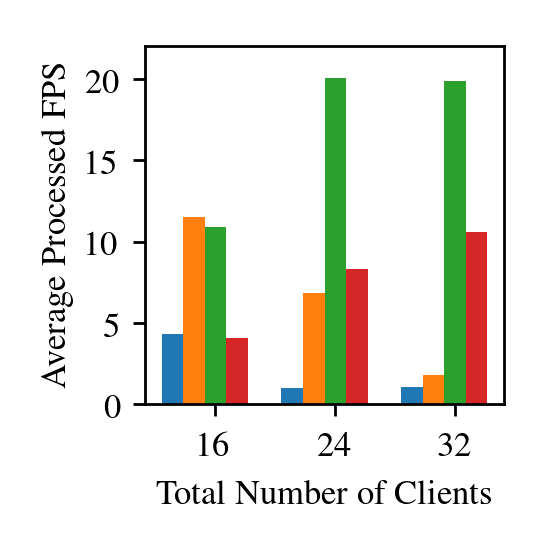

[3 4 4 5 6 6 7 8]
[4.31666667 1.01111111 1.04166667]
[3 4 4 5 6 6 7 8]
[11.48333333  6.81666667  1.83055556]
[3 4 4 5 6 6 7 8]
[10.86388889 20.05833333 19.85277778]
[3 4 4 5 6 6 7 8]
[ 4.075       8.31111111 10.60555556]


In [299]:
# Plot processed fps
for scheme in ['baseline', 'ours']:
    app_frames = pd.DataFrame()
    
    for exp in sec6_exps:
        df = pd.read_sql(
            "select app, count(*)/count(distinct name) as frames from ExpLatency where name like %(name)s group by app",
            schema.engine,
            params={'name': 'sec6-{}-{}'.format(scheme, exp),}
        )
        
        df['exp'] = exp
        
        app_frames = app_frames.append(df, ignore_index=True)
        
#     print(app_frames)
    
    fig, ax = plt.subplots()
    ind = np.arange(len(sec6_exps))
    width = .18
    
    for i, app in enumerate(apps):
        x = ind + width*i
        this_app = app_frames[app_frames['app']==app]
        print(this_app_clients)
        # y is average fps
        y = this_app['frames'].values / (4 * 90)  # hard code
        print(y)
        
        ax.bar(x, y, width, label=pretty_app(app))
    
    ax.set_xticks(ind + width * len(apps) / 2 )
    ax.set_xticklabels(np.array(sec6_exps)*4)  # hard code
    ax.set_xlabel('Total Number of Clients')
    ax.set_ylabel('Average Processed FPS')
#     ax.set_yticks([0, 5, 10, 15])
    ax.set_ylim([0, 22])
#     ax.legend(loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=4)

    fig.set_size_inches((2.2, 2.2))
    fig.tight_layout()
    fig.savefig('fig-{}-fps-{}.pdf'.format(prefix, scheme), bbox_inches='tight')